In [35]:
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import numpy as np
import warnings
import math
import re

tqdm.pandas()
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

%run ../src/utils.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
train = pd.read_csv('../data/raw/data_train.zip', index_col='Unnamed: 0', low_memory=True)
train.shape

(814262, 11)

In [37]:
test = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
test.shape

(202937, 11)

In [38]:
data = pd.concat([train, test], axis=0)
data.shape

(1017199, 11)

# Distance Evaluation
Euclidian, Minkowski, Haversine distances.

In [39]:
def euclidian_distance(x_one, y_one, x_two, y_two):
    return np.sqrt(np.power((x_one-x_two), 2) + np.power((y_one-y_two), 2))

def minkowski_distance(x_one, y_one, x_two, y_two):
    return abs(x_one-x_two) + abs(y_one-y_two)

data['euclidian_distance'] = np.sqrt(np.power(data.x_entry.values-data.x_exit.values, 2)+np.power(data.y_entry.values-data.y_exit.values, 2))

data['minkowski_distance'] = np.abs(data.x_entry.values-data.x_exit.values) + np.abs(data.y_entry.values-data.y_exit.values)

In [40]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

data['harvesine_distance'] = [haversine(x1, y1, x2, y2) for x1, y1, x2, y2 in zip(data.x_entry, data.y_entry,
                                                                                data.x_exit, data.y_exit)]

In [262]:
data = data[data.euclidian_distance!=0]
data.shape

(491966, 47)

### Distances from Center Borders
Euclidian distance from point to city center borders.

In [331]:
from shapely.geometry import Point, Polygon, LineString

center['left_border']  = LineString([(center['x_min'], center['y_min']), (center['x_min'], center['y_max'])])
center['right_border'] = LineString([(center['x_max'], center['y_min']), (center['x_max'], center['y_max'])])

center['lower_border']  = LineString([(center['x_min'], center['y_min']), (center['x_max'], center['y_min'])])
center['upper_border']  = LineString([(center['x_min'], center['y_max']), (center['x_max'], center['y_max'])])

center['left_border'].distance(Point(center['x_max'], center['y_min']))

20000.0

In [332]:
def distance_to_border(x, y, direction):
    return center[direction + '_border'].distance(Point(x, y))

data['distance_left_border'] = [distance_to_border(x, y, direction='left') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_right_border'] = [distance_to_border(x, y, direction='right') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_lower_border'] = [distance_to_border(x, y, direction='lower') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_upper_border'] = [distance_to_border(x, y, direction='upper') for x, y in zip(data.x_entry, data.y_entry)]

## Target feature

In [333]:
def is_inside_city(x, y):
    if (3750901.5068 <= x <= 3770901.5068) and (-19268905.6133 <= y <= -19208905.6133):
        return 1
    else:
        return 0

data['is_inside_city_entry'] = [is_inside_city(x, y) for x, y in zip(data.x_entry, data.y_entry)]
data['is_inside_city_exit'] = [is_inside_city(x, y) for x, y in zip(data.x_exit, data.y_exit)]

# Grid Sections
We'll start off dividing our trajectory map in grids meant to cover any posible entry point in our data

In [334]:
xmin, ymin, xmax, ymax = data.x_entry.min(), data.y_entry.min(), data.x_entry.max(), data.y_entry.max()

xmax-xmin, ymax-ymin

(36068.62821192667, 340258.3224131949)

In [43]:
from shapely.geometry import Polygon

# 10x3 grids, given the height/width ratio is predominantly vertical
y_count = 10
x_count = 3

grid_h = (ymax-ymin)/y_count
grid_w = (xmax-xmin)/x_count

grids = {'{}_{}'.format(i+1,j+1): Polygon([
            (xmin + grid_w*i, ymin + grid_h*j), (xmin + grid_w*i, ymin + grid_h*(j+1)),
            (xmin + grid_w*(i+1), ymin + grid_h*(j+1)), (xmin + grid_w*(i+1), ymin + grid_h*j)]) \
         for i in range(0, x_count) \
         for j in range(0, y_count)}

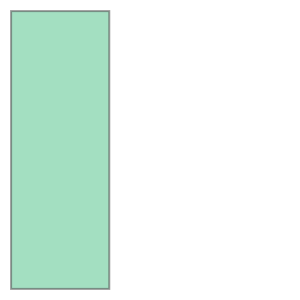

In [46]:
grids['1_1']

In [47]:
grid_cols = ['entry_grid_' + grid for grid in grids.keys()]
data = data.reindex(columns=data.columns.tolist() + grid_cols)

In [48]:
for (_, grid), col in zip(grids.items(), grid_cols):
    data[col] = data.apply(lambda row: grid.contains(Point(row['x_entry'], row['y_entry'])), axis=1)

In [49]:
data[grid_cols] = data[grid_cols].astype(int)

In [175]:
for col in grid_cols:
    data.loc[data[col] == 1, 'neighbors'] = data[col].sum()

data.head(5)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,entry_grid_3_2,entry_grid_3_3,entry_grid_3_4,entry_grid_3_5,entry_grid_3_6,entry_grid_3_7,entry_grid_3_8,entry_grid_3_9,entry_grid_3_10,neighbors
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0,0,0,0,0,0,0,0,0,5729.0
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,0,0,0,0,0,0,0,0,0,11925.0
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,0,0,0,0,0,0,0,0,0,31417.0
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,0,0,0,0,0,0,0,0,0,31417.0
5,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_5,15:02:31,15:18:33,NaN,NaN,NaN,3.744945e+06,-1.928183e+07,3.744785e+06,...,0,0,0,0,0,0,0,0,0,31417.0


# Clustering
Based on new grid input data, we'll explore clustering results for our train set.

In [335]:
from sklearn.cluster import KMeans

cluster_cols = ['x_entry', 'y_entry', 'neighbors', 'is_inside_city_entry',
                'distance_left_border', 'distance_right_border', 'distance_lower_border', 'distance_upper_border'] + grid_cols

train_data = data[data.hash.isin(train.hash.unique())]

kmeans = KMeans(n_clusters=4, random_state=20)
kmeans.fit(train_data[grid_cols])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=20, tol=0.0001, verbose=0)

In [336]:
kmeans.labels_

array([0, 0, 3, ..., 3, 3, 0])

In [337]:
len(kmeans.labels_), train_data.shape[0]

(380248, 380248)

In [338]:
train_data['cluster'] = kmeans.labels_

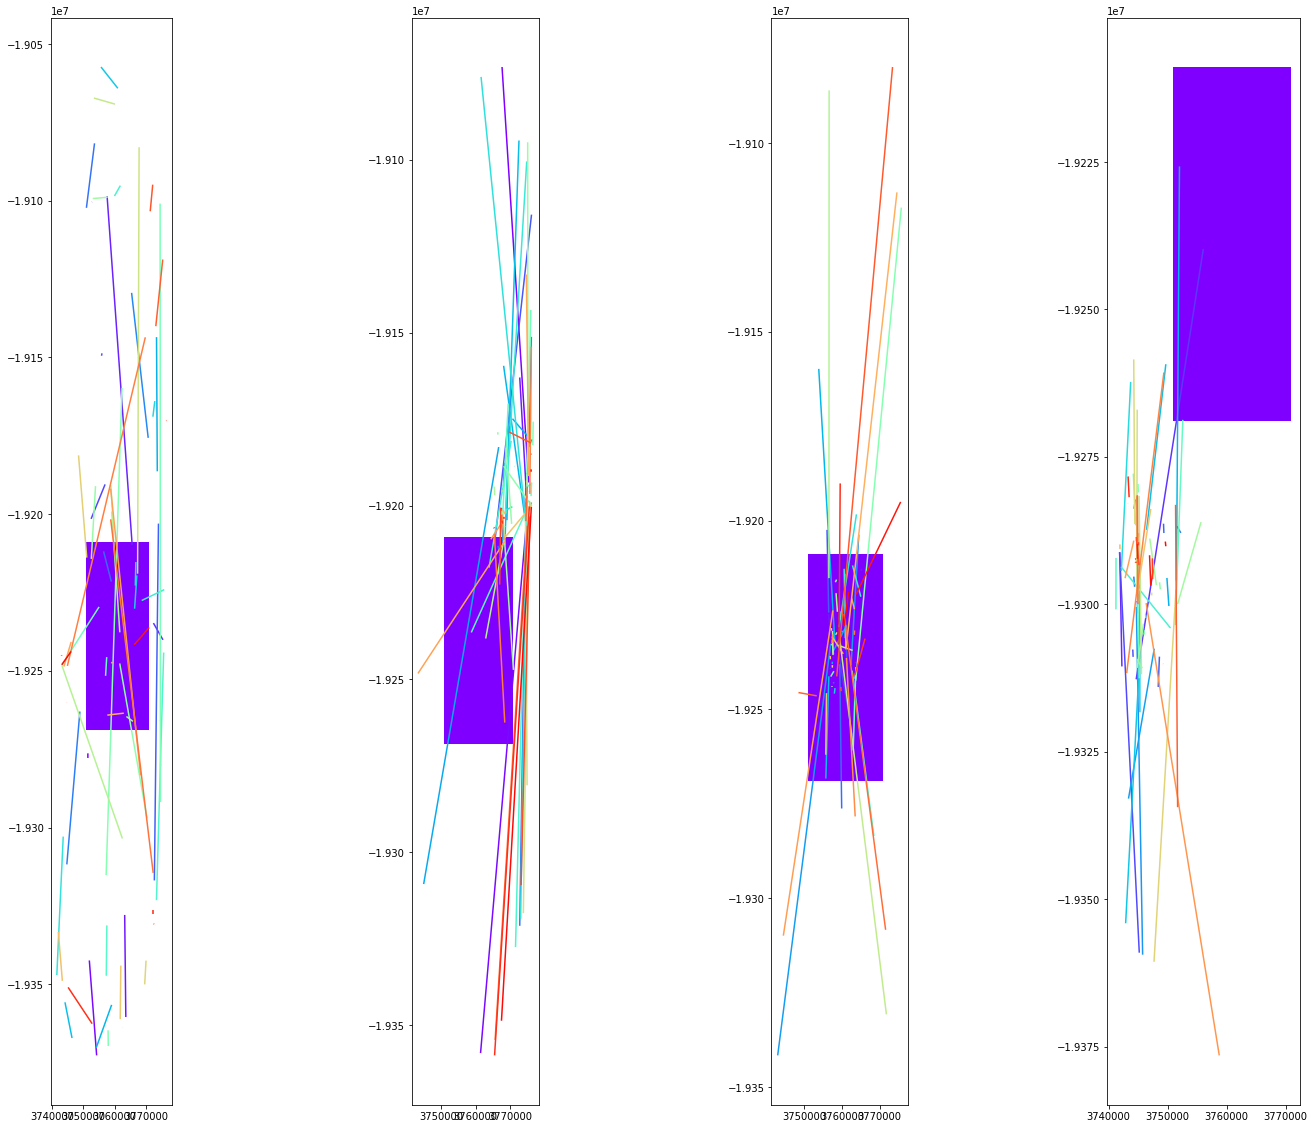

In [339]:
train_data['time_entry'] = pd.to_timedelta(train_data.time_entry)
train_data['time_exit'] = pd.to_timedelta(train_data.time_exit)

trajectory_count = 600
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(25, 20))

cluster1 = train_data[train_data.cluster == 0]
cluster2 = train_data[train_data.cluster == 1]
cluster3 = train_data[train_data.cluster == 2]
cluster4 = train_data[train_data.cluster == 3]

geoplot(cluster1.tail(trajectory_count), ax=ax1)
geoplot(cluster2.tail(trajectory_count), ax=ax2)
geoplot(cluster3.tail(trajectory_count), ax=ax3)
geoplot(cluster4.tail(trajectory_count), ax=ax4)

# Cluster Analysis

In [340]:
(cluster1.euclidian_distance.mean(),
cluster2.euclidian_distance.mean(),
cluster3.euclidian_distance.mean(),
cluster4.euclidian_distance.mean())

(31417.065143082735, 23799.67959434604, 16220.56529613586, 19533.01220520981)

In [341]:
arr = lambda: np.empty([4]).tolist()

longest, shortest = arr(), arr()
short_staying_in, short_staying_out = arr(), arr()
short_leaving_center, short_entering_center = arr(), arr()
long_staying_in, long_staying_out = arr(), arr()
long_leaving_center, long_entering_center = arr(), arr()

for i, c in enumerate([cluster1, cluster2, cluster3, cluster4]):
    longest[i] = c.sort_values('euclidian_distance', ascending=False).head(c.shape[0]//2).copy()
    shortest[i] = c.sort_values('euclidian_distance', ascending=True).head(c.shape[0]//2).copy()

    short_staying_in[i] = shortest[i][(shortest[i].is_inside_city_entry == 1) & (shortest[i].is_inside_city_exit == 1)]
    short_staying_out[i] = shortest[i][(shortest[i].is_inside_city_entry == 0) & (shortest[i].is_inside_city_exit == 0)]
    short_leaving_center[i] = shortest[i][(shortest[i].is_inside_city_entry == 1) & (shortest[i].is_inside_city_exit == 0)]
    short_entering_center[i] = shortest[i][(shortest[i].is_inside_city_entry == 0) & (shortest[i].is_inside_city_exit == 1)]

    long_staying_in[i] = longest[i][(longest[i].is_inside_city_entry == 1) & (longest[i].is_inside_city_exit == 1)]
    long_staying_out[i] = longest[i][(longest[i].is_inside_city_entry == 0) & (longest[i].is_inside_city_exit == 0)]
    long_leaving_center[i] = longest[i][(longest[i].is_inside_city_entry == 1) & (longest[i].is_inside_city_exit == 0)]
    long_entering_center[i] = longest[i][(longest[i].is_inside_city_entry == 0) & (longest[i].is_inside_city_exit == 1)]

In [402]:
def cluster_plot(i, short_qtt=500, long_qtt=500):
    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(ncols=4, nrows=2, figsize=(30, 40))

    ax_font = 20
    fig.suptitle('Cluster {}'.format(i+1), fontsize=25)

    # Shortest
    shortest_len = len(shortest[i])
    short_probs = [
        100 * len(short_staying_in[i]) / shortest_len,
        100 * len(short_staying_out[i]) / shortest_len,
        100 * len(short_leaving_center[i]) / shortest_len,
        100 * len(short_entering_center[i]) / shortest_len
    ]
    
    ax1.set_title('Staying in center: {:.3f}%'.format(short_probs[0]), fontsize=ax_font)
    if short_probs[0] > 0.0 and short_staying_in[i].shape[0] > 0:
        geoplot(short_staying_in[i].head(short_qtt), ax=ax1)
    
    ax2.set_title('Staying out of center: {:.3f}%'.format(short_probs[1]), fontsize=ax_font)
    if short_probs[1] > 0.0 and short_staying_out[i].shape[0] > 0:
        geoplot(short_staying_out[i].head(short_qtt), ax=ax2)
    
    ax3.set_title('Entering: {:.3f}%'.format(short_probs[2]), fontsize=ax_font)
    if short_probs[2] > 0.0 and short_entering_center[i].shape[0] > 0:
        geoplot(short_entering_center[i].head(short_qtt), ax=ax3)
    
    ax4.set_title('Leaving: {:.3f}%'.format(short_probs[3]), fontsize=ax_font)
    if short_probs[3] > 0.0 and short_leaving_center[i].shape[0] > 0:
        geoplot(short_leaving_center[i].head(short_qtt), ax=ax4)

    # Longest
    longest_len = len(longest[i])
    long_probs = [
        100 * len(long_staying_in[i]) / longest_len,
        100 * len(long_staying_out[i]) / longest_len,
        100 * len(long_leaving_center[i]) / longest_len,
        100 * len(long_entering_center[i]) / longest_len
    ]
    
    ax5.set_title('Staying in center: {:.3f}%'.format(long_probs[0]), fontsize=ax_font)
    if long_probs[0] > 0.0 and long_staying_in[i].shape[0] > 0:
        geoplot(long_staying_in[i].head(long_qtt), ax=ax5)
    
    ax6.set_title('Staying out of center: {:.3f}%'.format(long_probs[1]), fontsize=ax_font)
    if long_probs[1] > 0.0 and long_staying_out[i].shape[0] > 0:
        geoplot(long_staying_out[i].head(long_qtt), ax=ax6)
    
    ax7.set_title('Entering: {:.3f}%'.format(long_probs[2]), fontsize=ax_font)
    if long_probs[2] > 0.0 and long_entering_center[i].shape[0] > 0:
        geoplot(long_entering_center[i].head(long_qtt), ax=ax7)
    
    ax8.set_title('Leaving: {:.3f}%'.format(long_probs[3]), fontsize=ax_font)
    if long_probs[3] > 0.0 and long_leaving_center[i].shape[0] > 0:
        geoplot(long_leaving_center[i].head(long_qtt), ax=ax8)

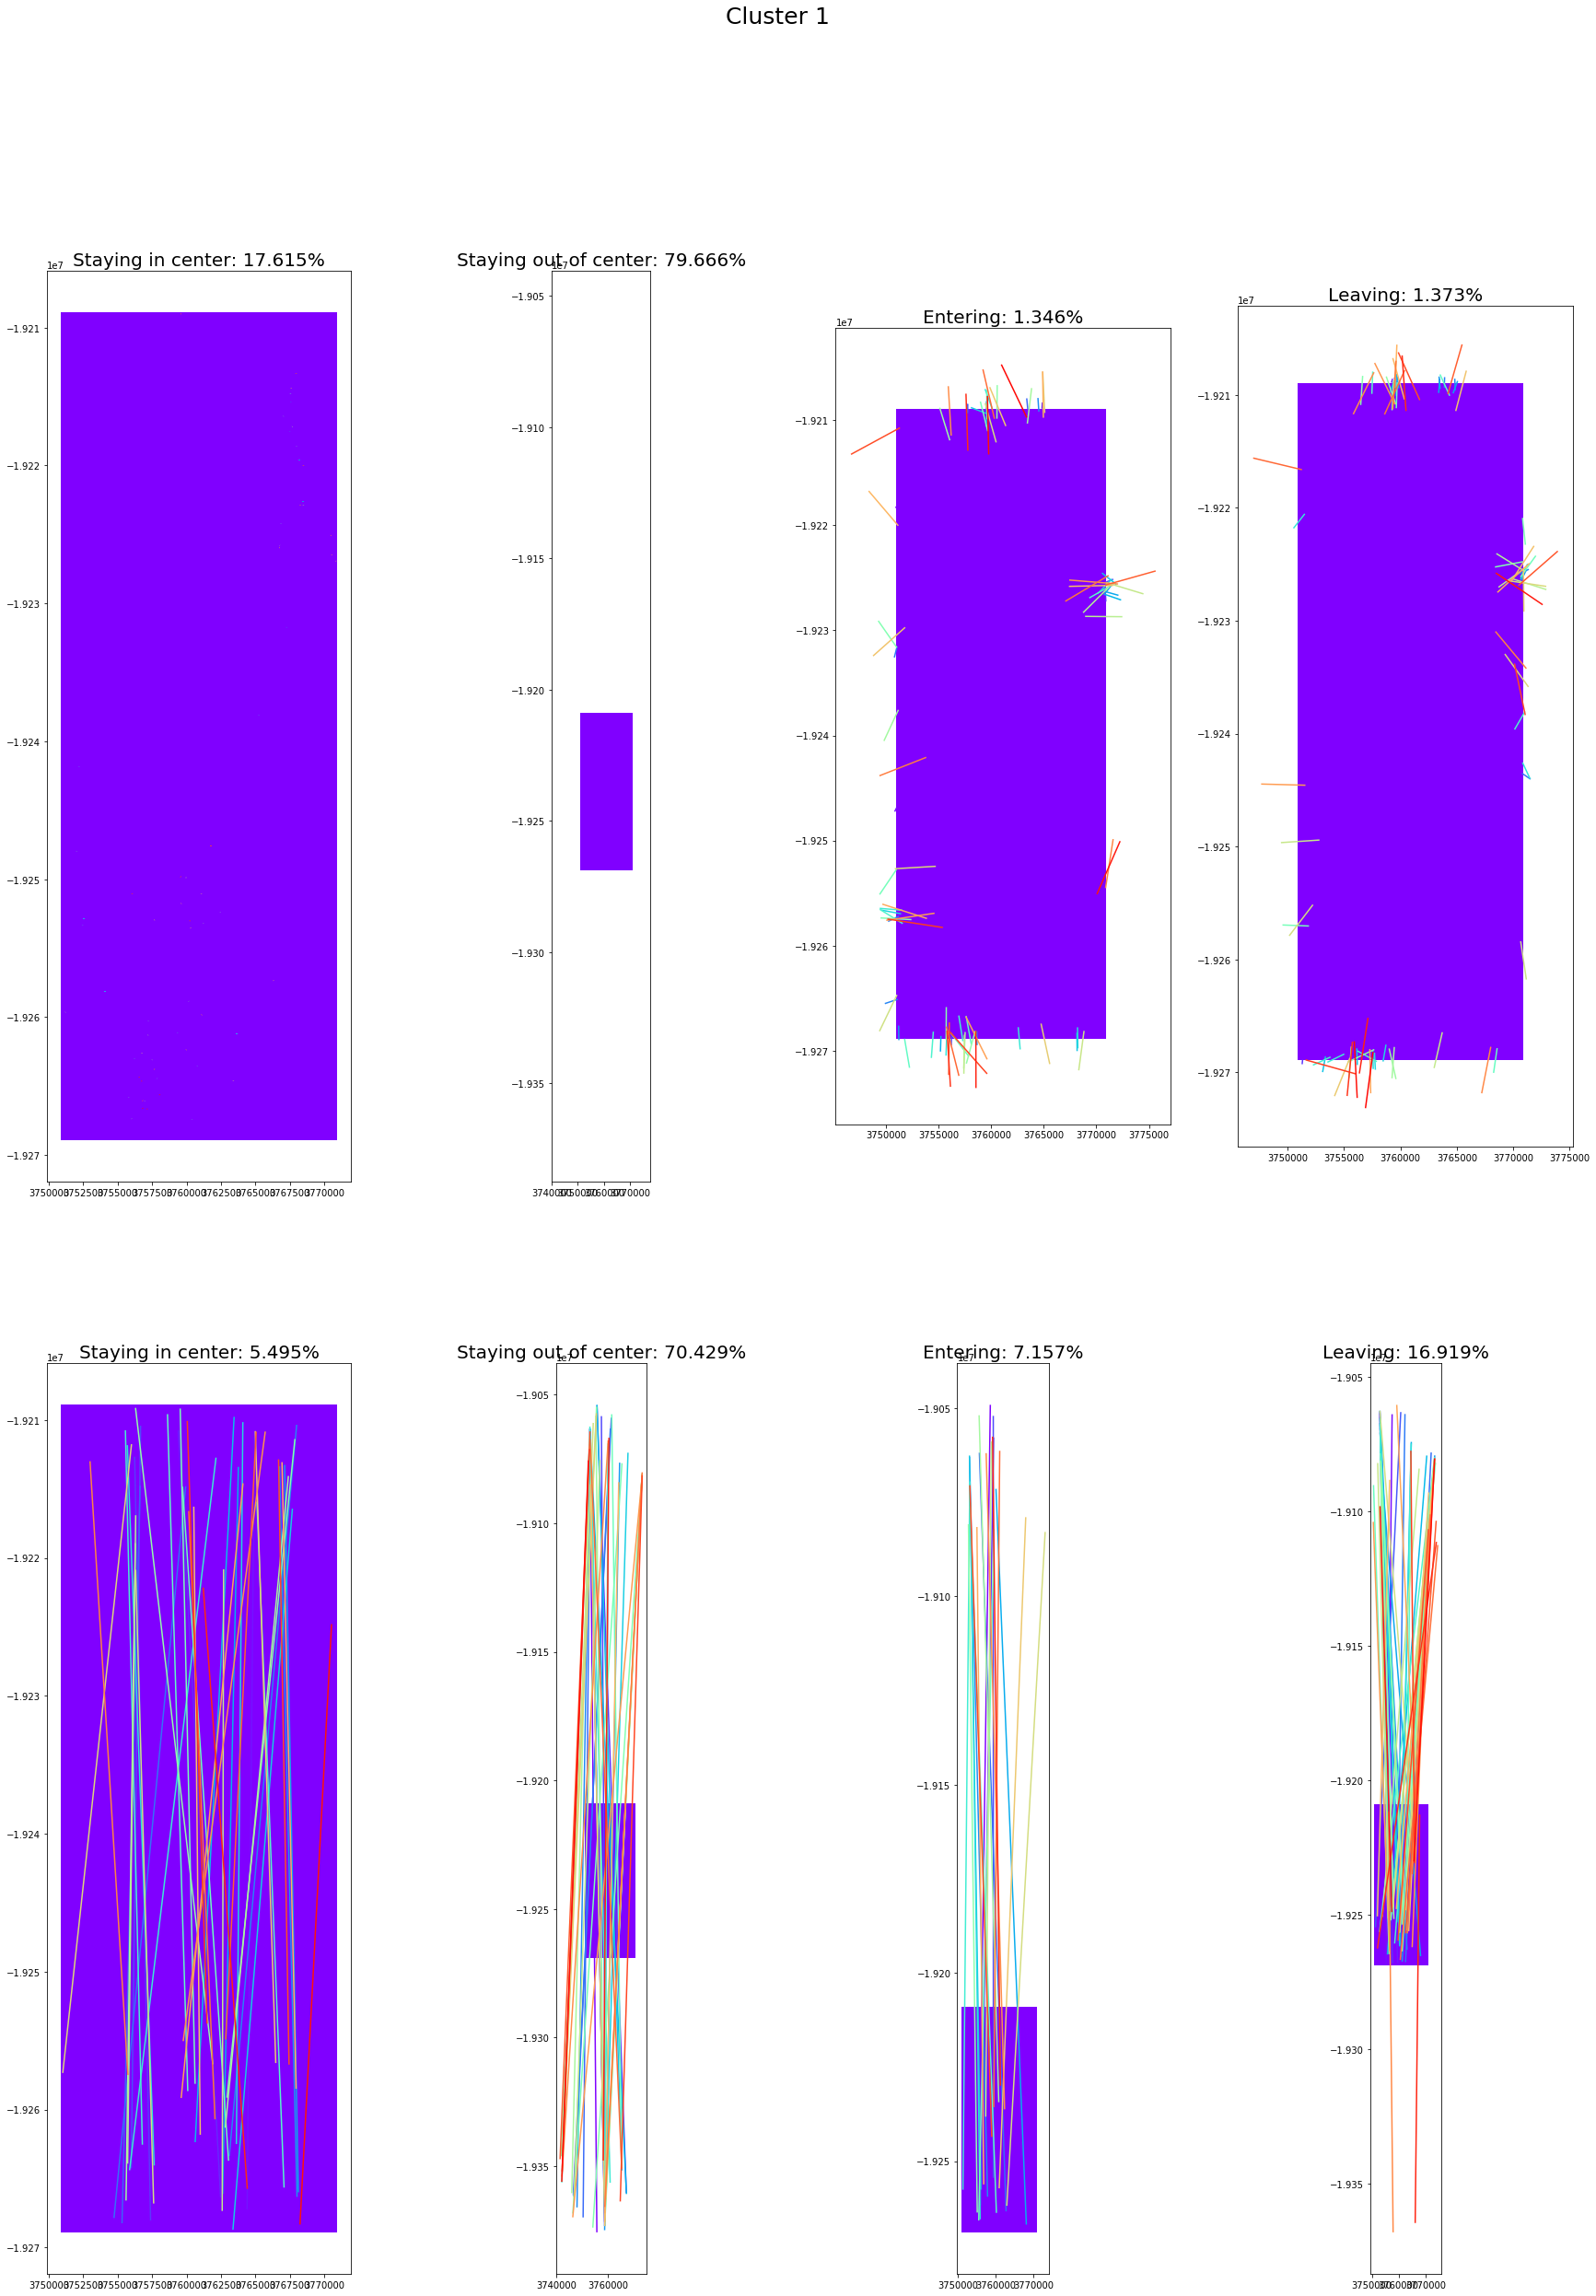

In [403]:
cluster_plot(0, short_qtt=800, long_qtt=400)

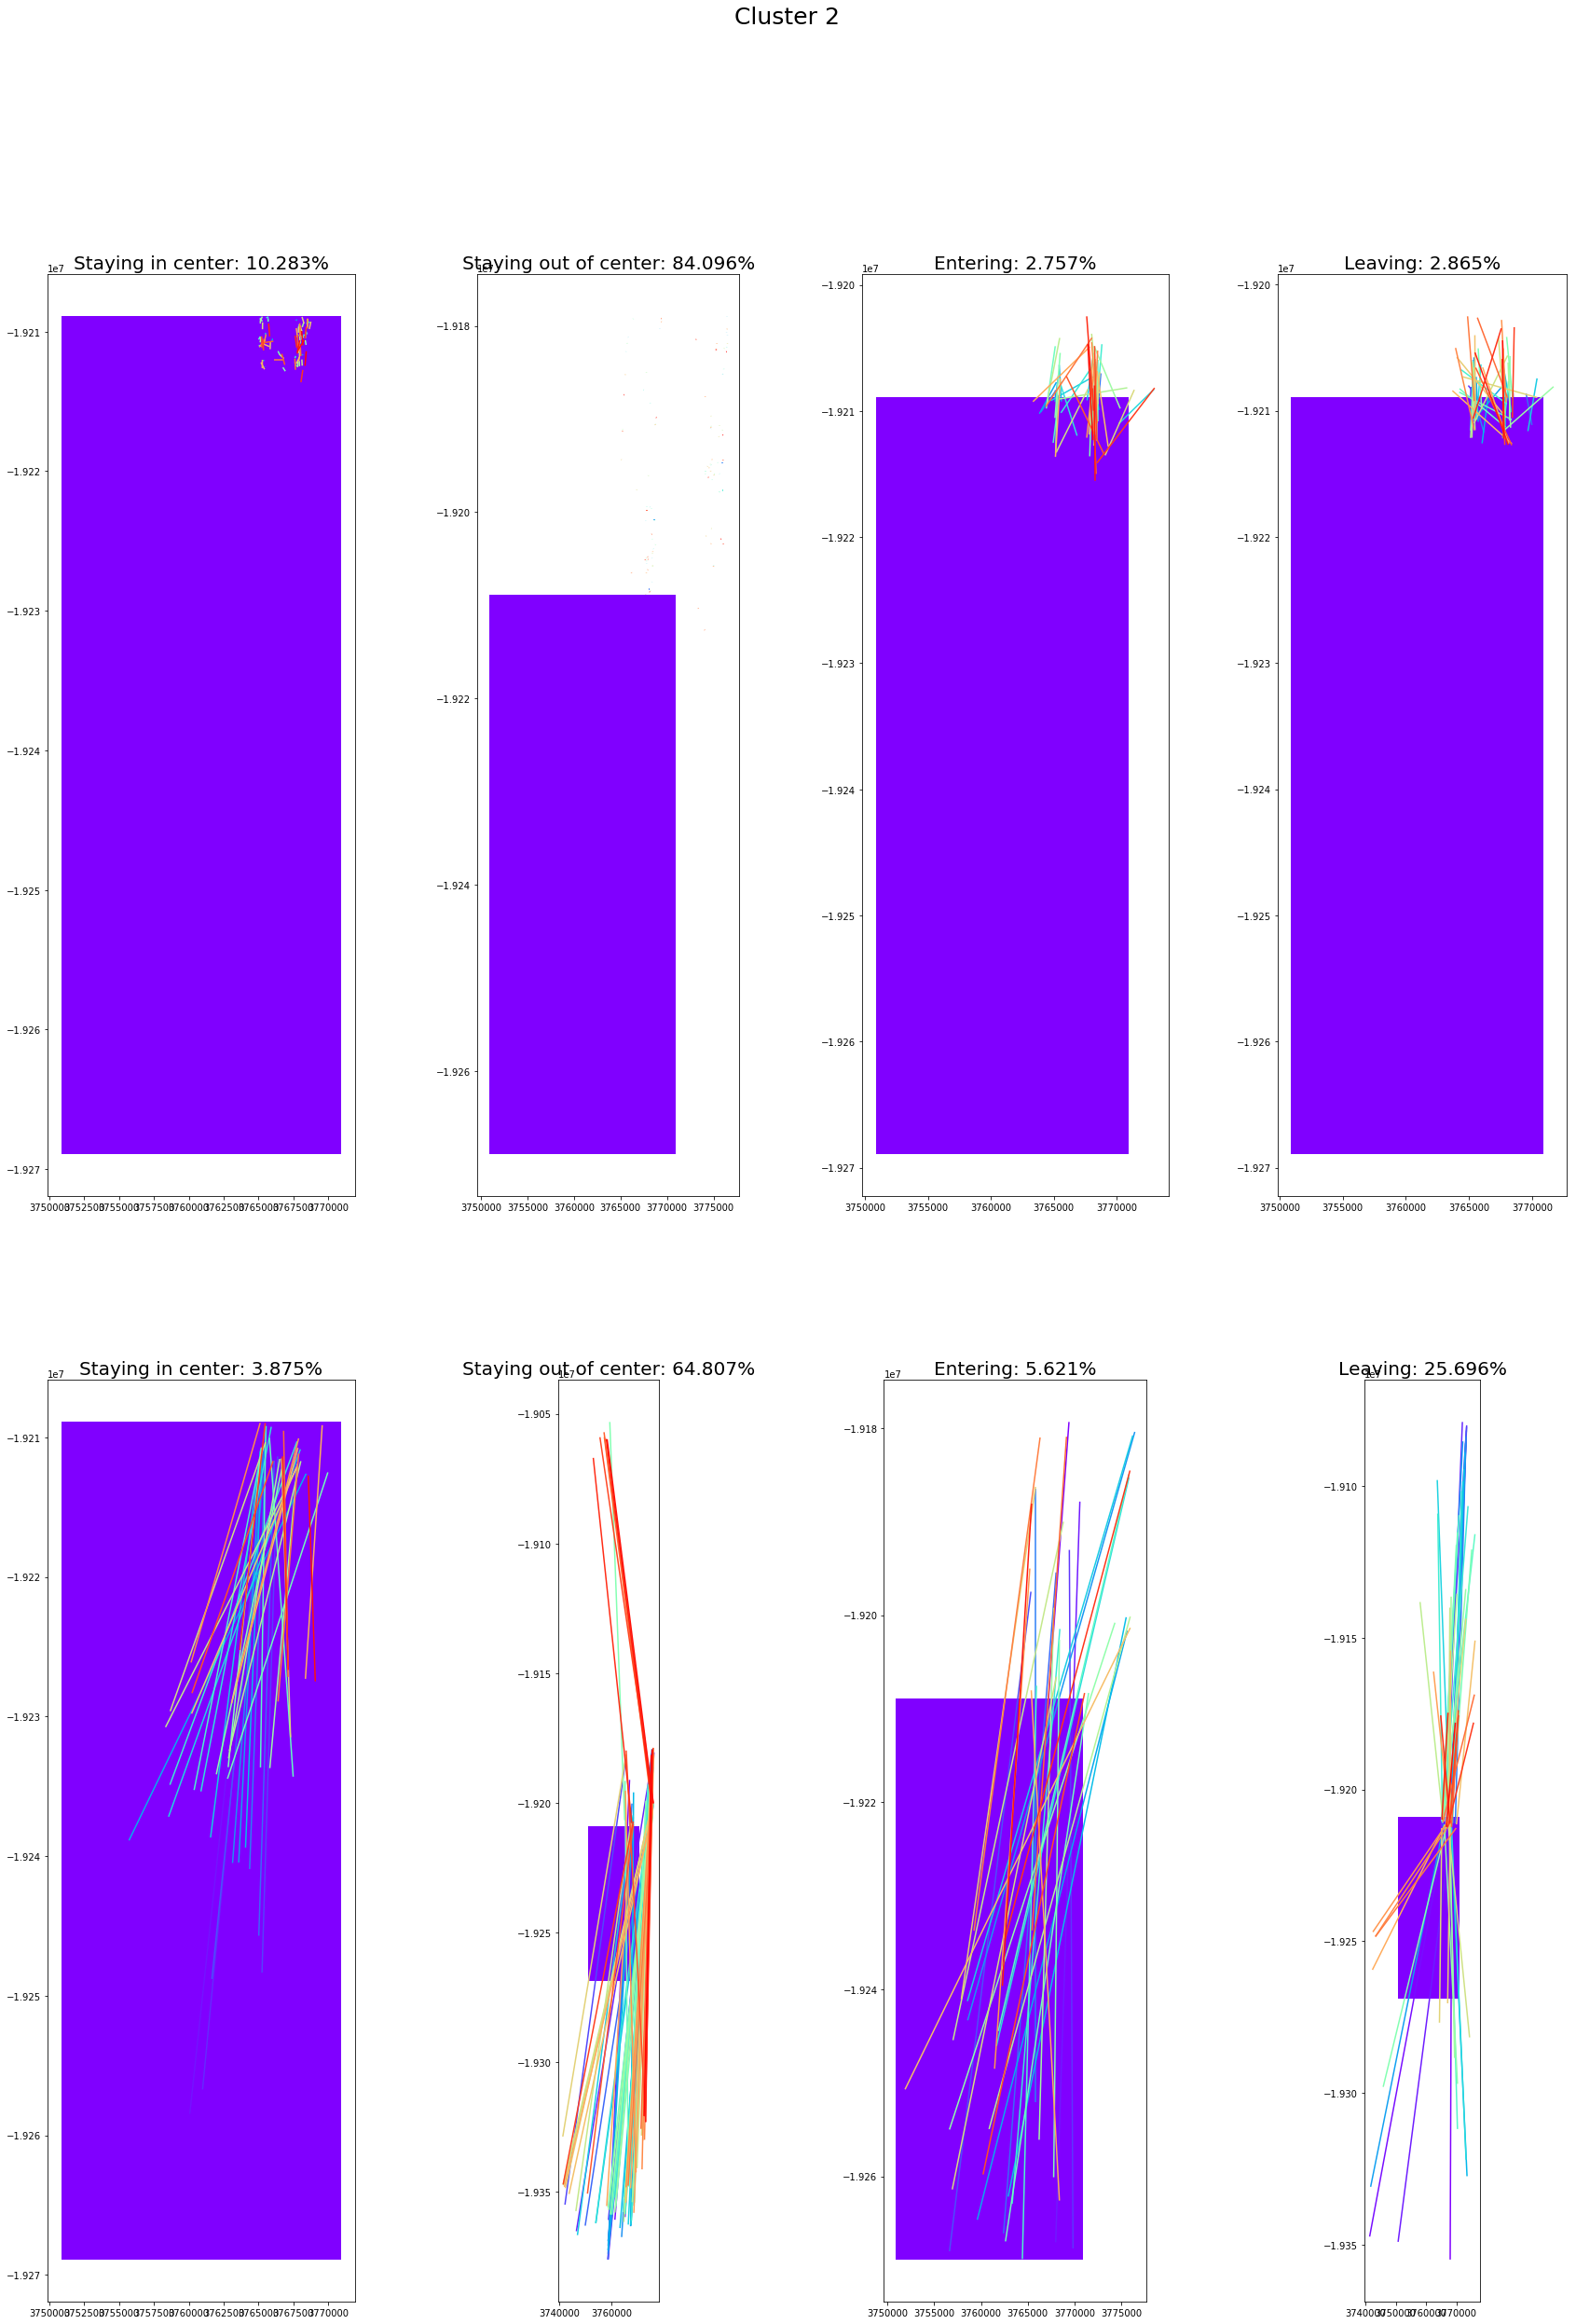

In [404]:
cluster_plot(1, short_qtt=800, long_qtt=400)

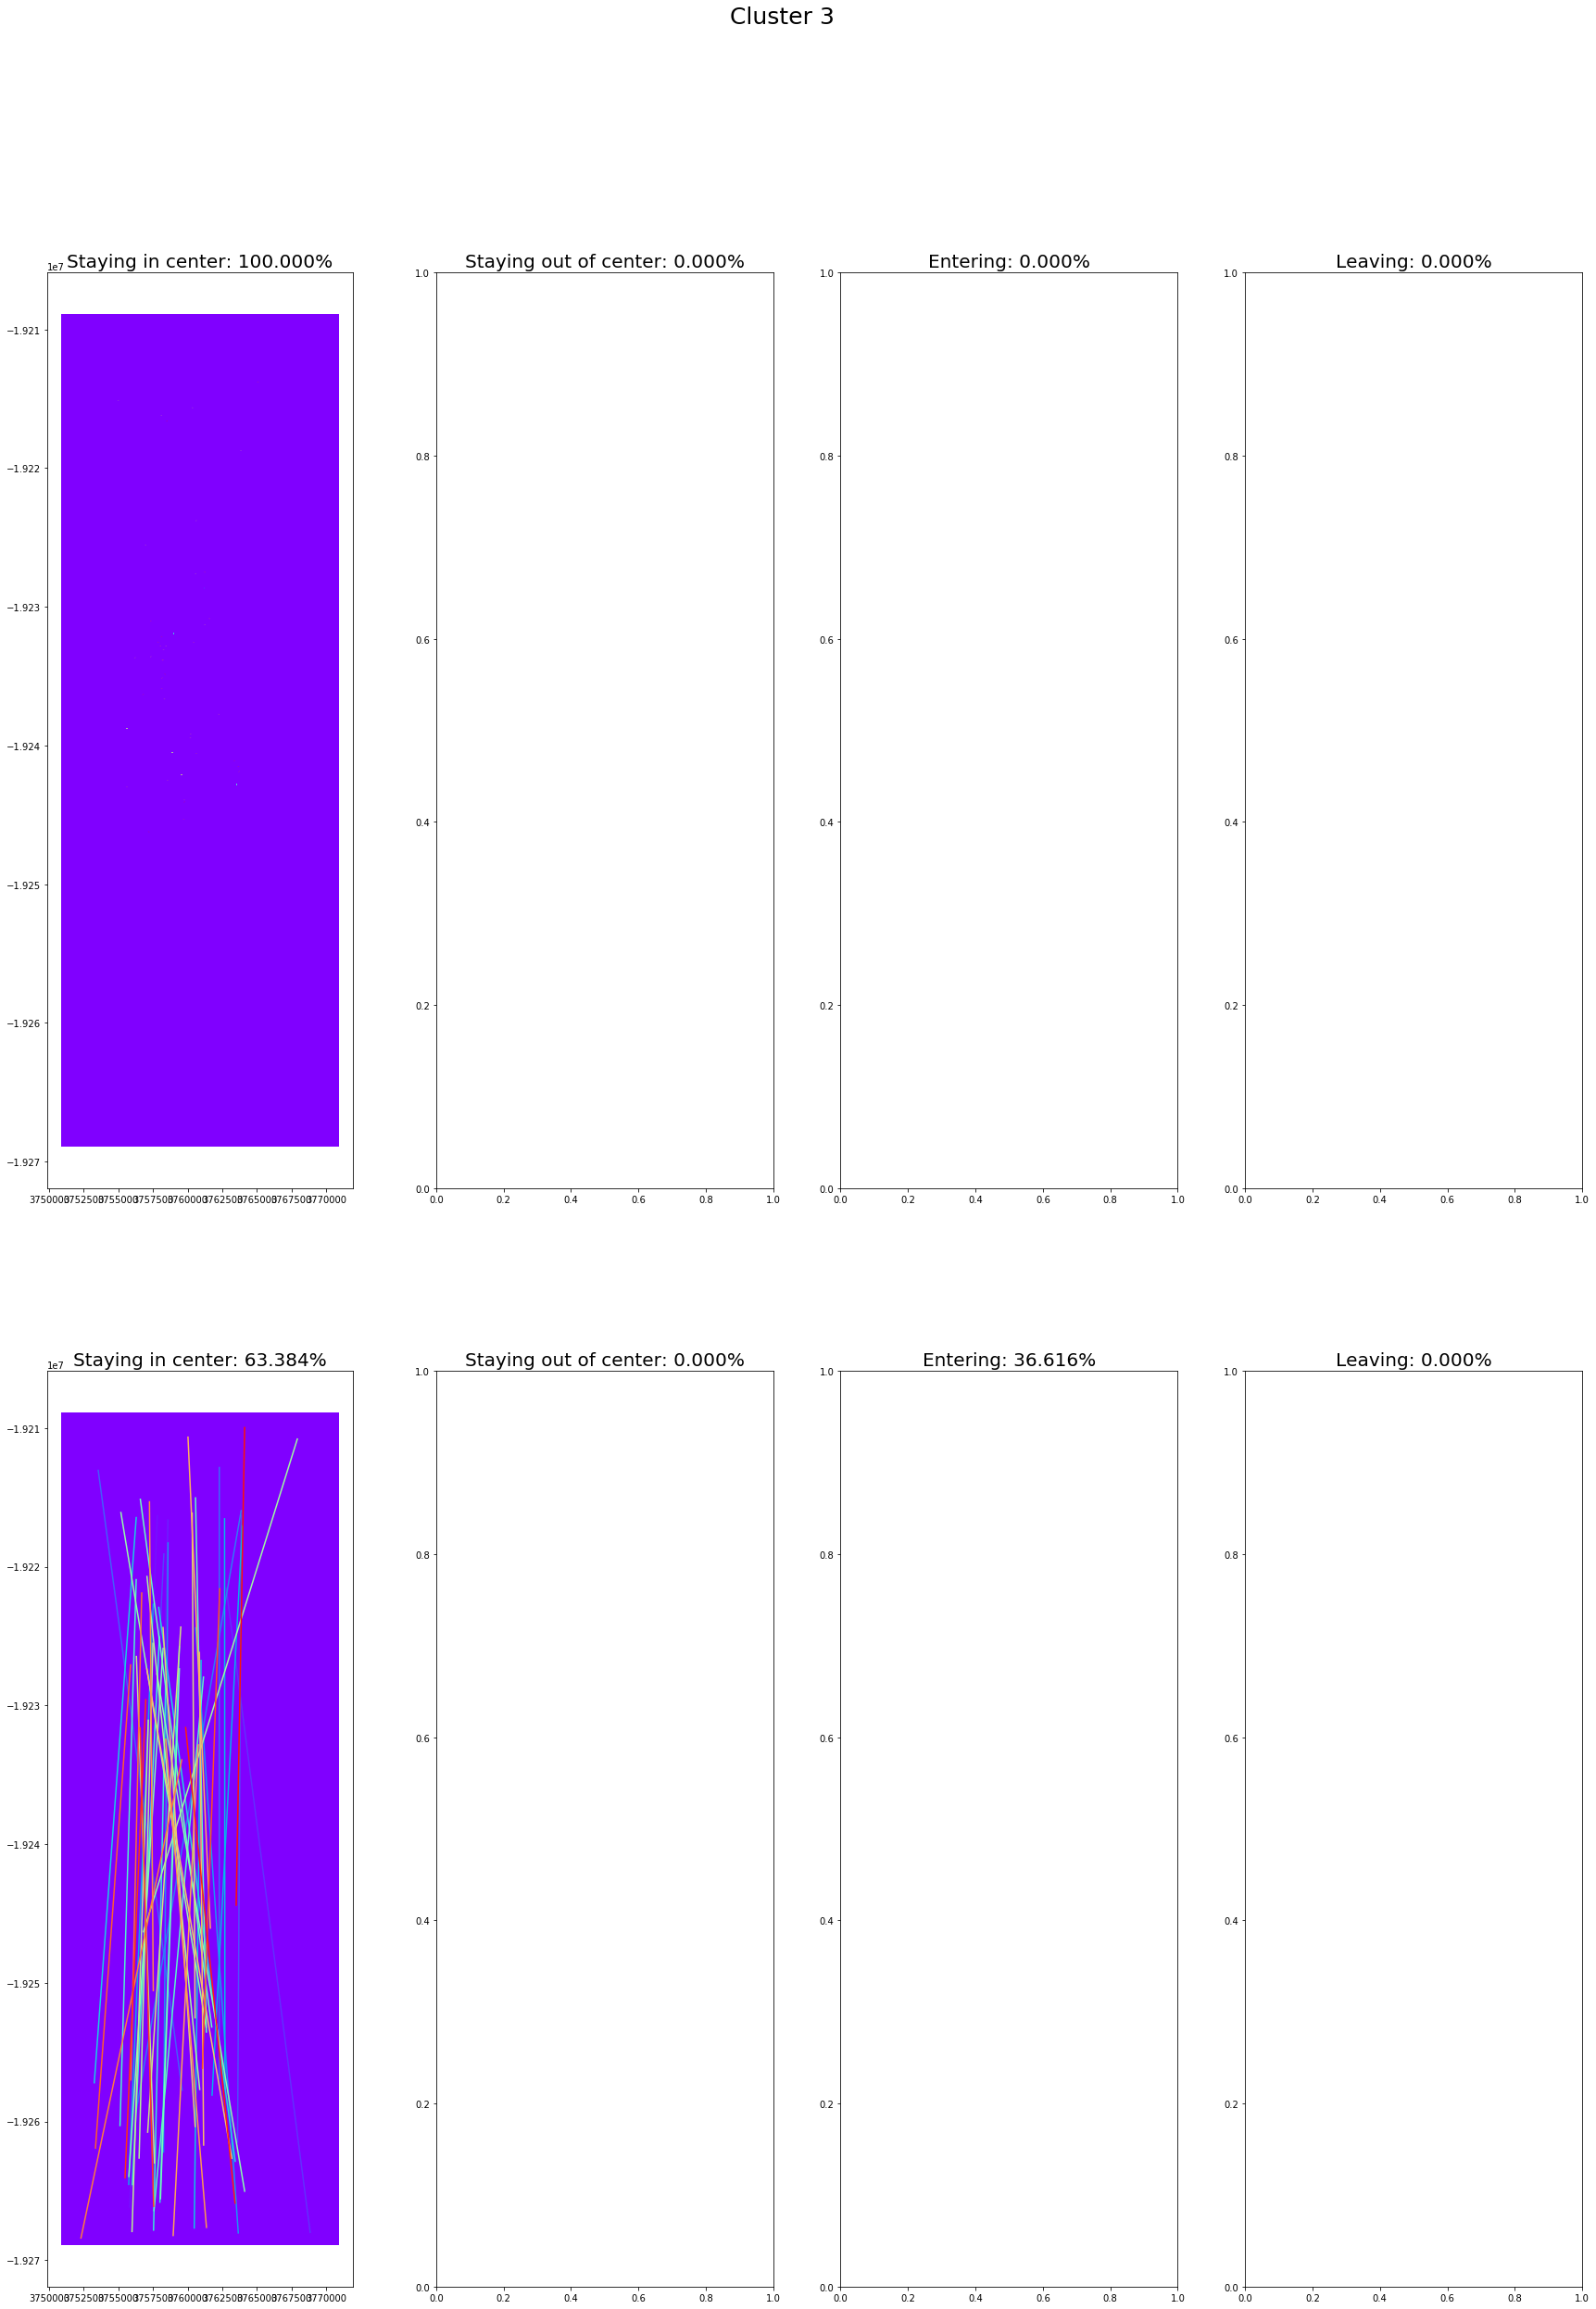

In [405]:
cluster_plot(2, short_qtt=800, long_qtt=400)

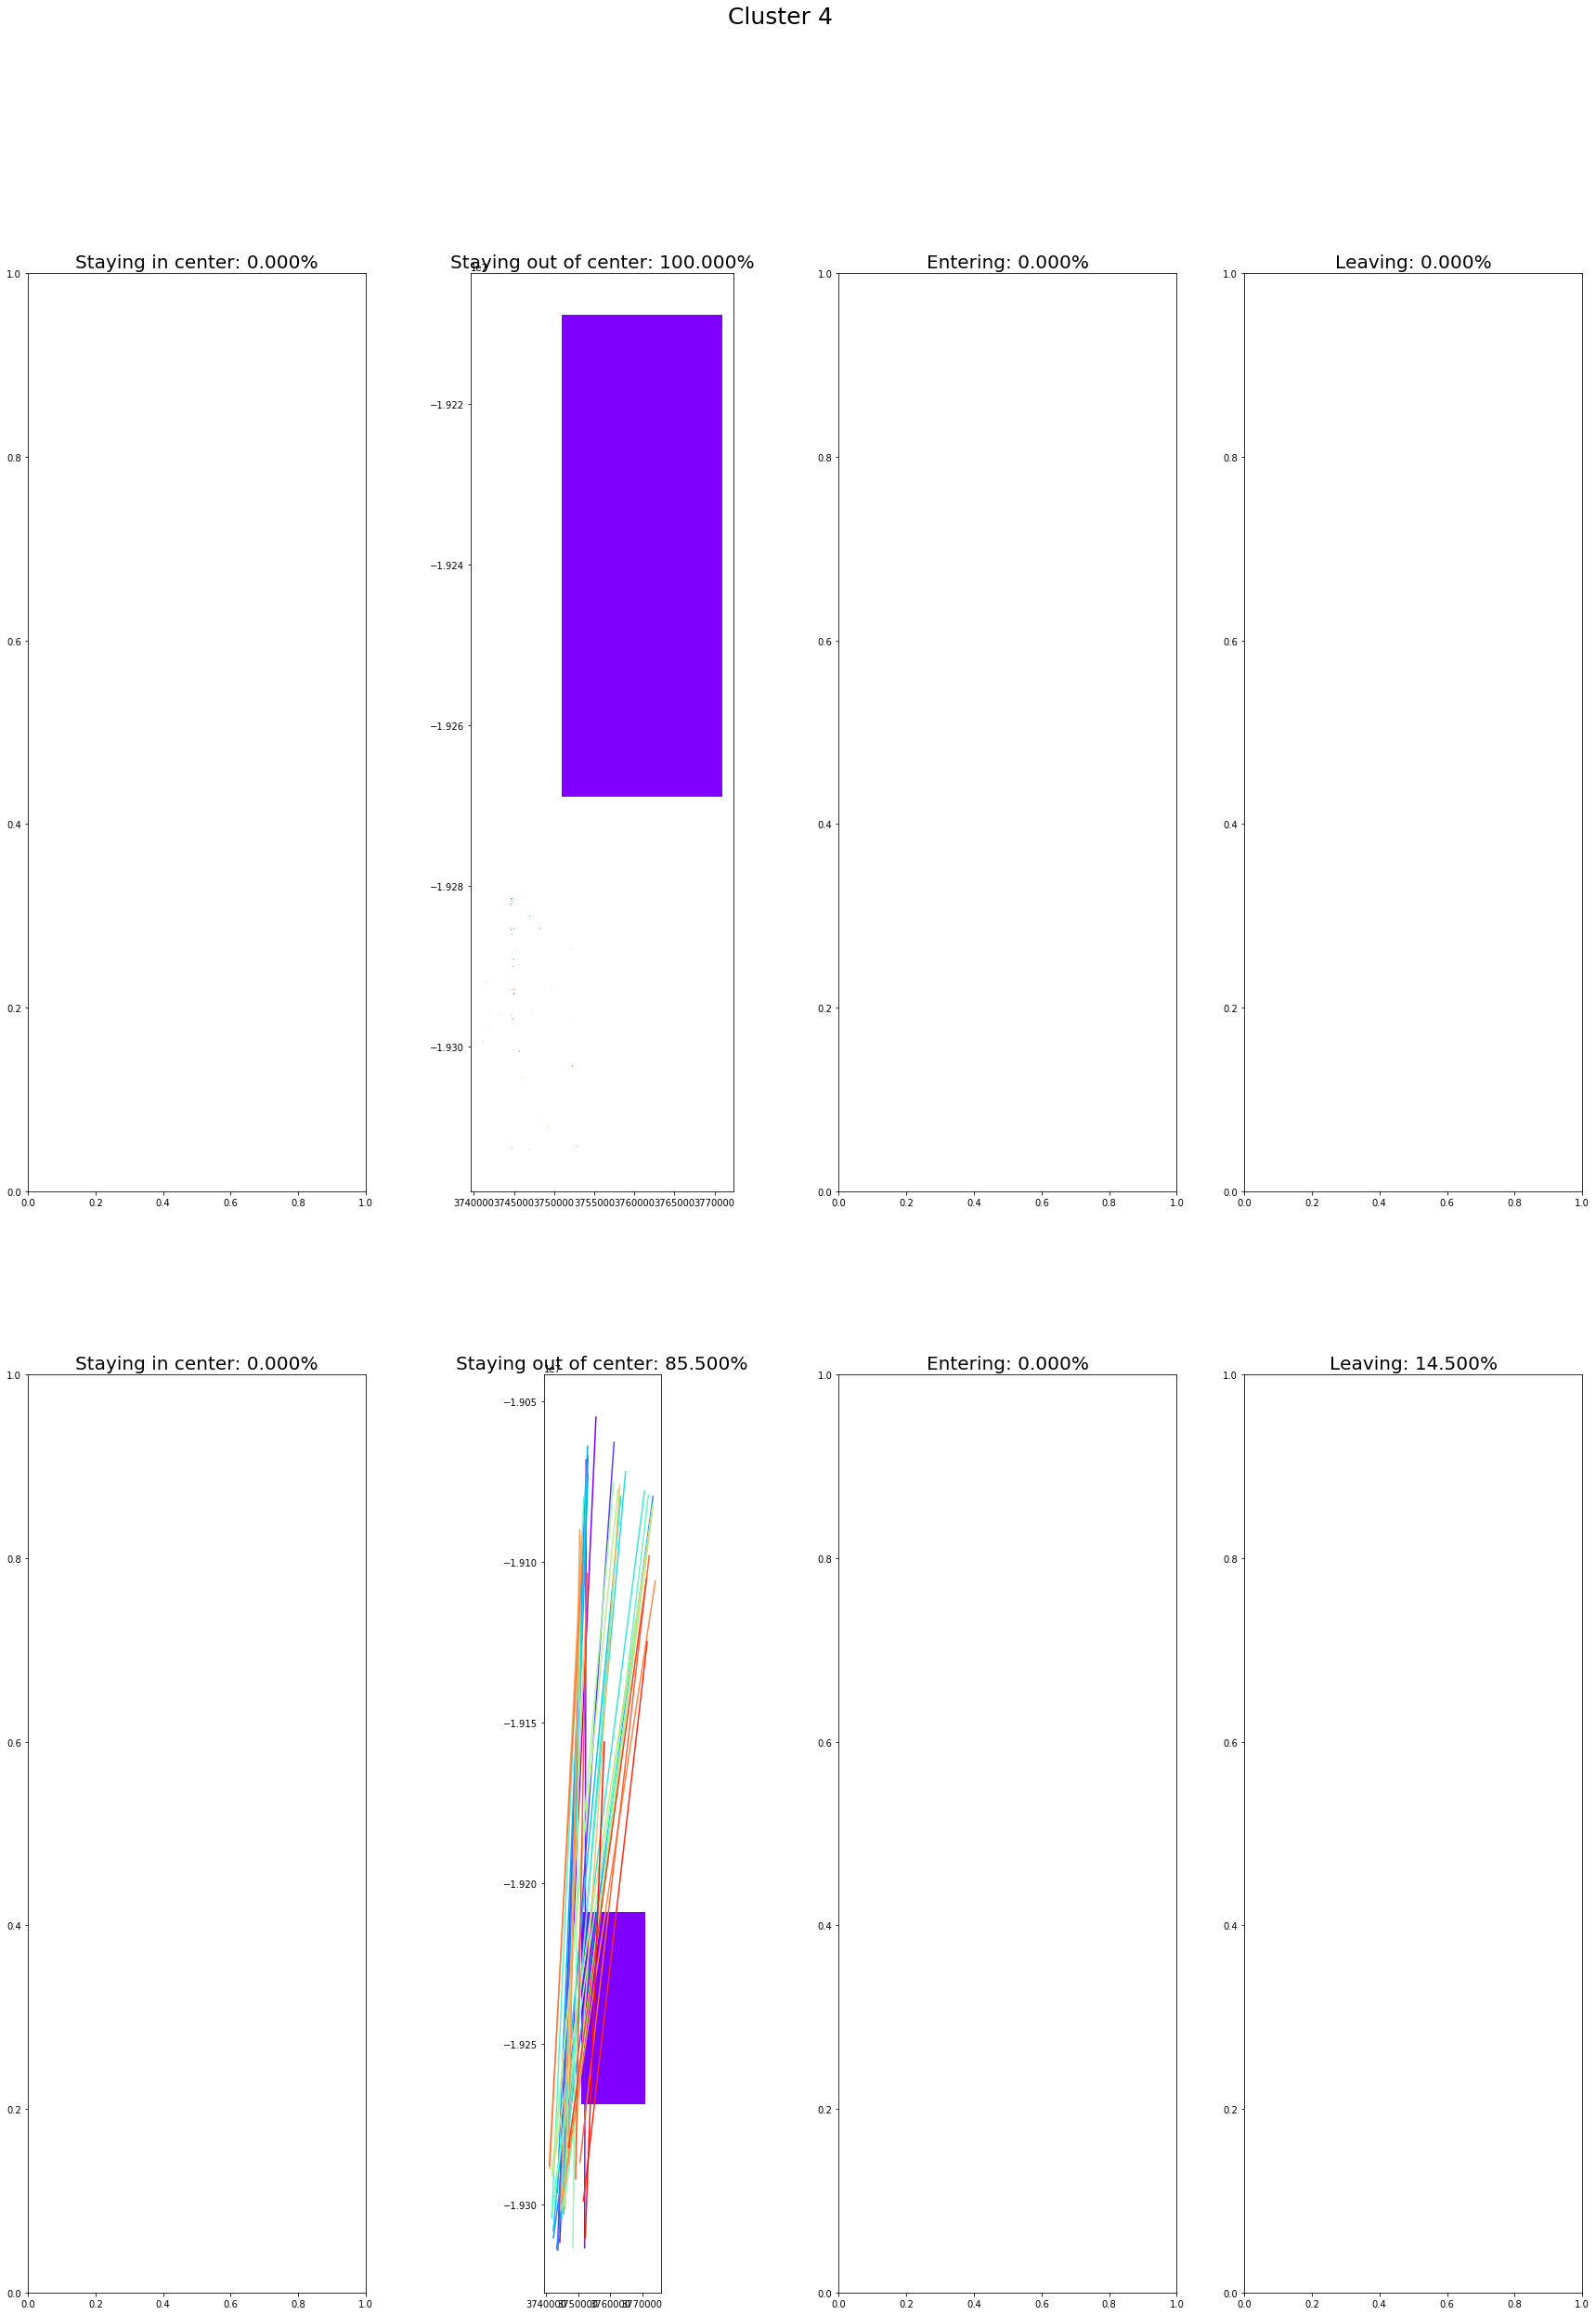

In [406]:
cluster_plot(3, short_qtt=800, long_qtt=400)

## Feature Engineering

In [352]:
data['last_x_entry'] = data.groupby('hash').x_exit.shift(1)
data['last_y_entry'] = data.groupby('hash').y_exit.shift(1)

angle_cols = [
    'cc_middle_angle', 'cc_xmin_ymin_angle', 'cc_xmax_ymin_angle', 'cc_xmin_ymax_angle', 'cc_xmax_ymax_angle'
]

data = data.reindex(columns=data.columns.tolist() + angle_cols)

data = data.progress_apply(entry_to_center_angles, axis=1)

data = data.drop(columns=['last_x_entry', 'last_y_entry'])

data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,is_inside_city_exit,distance_left_border,distance_right_border,distance_lower_border,distance_upper_border,cc_middle_angle,cc_xmin_ymin_angle,cc_xmax_ymin_angle,cc_xmin_ymax_angle,cc_xmax_ymax_angle
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0,114925.024135,116633.059928,174924.969304,114924.969304,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,0,54012.799354,59966.283785,54012.799354,113775.281047,0.137059,0.038653,0.188293,0.042244,0.310604
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,0,25386.747582,35858.533322,25386.747582,84874.048910,0.198812,0.120334,0.476339,0.057555,0.234039
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,0,24146.972686,34984.767305,24146.972686,83601.282594,0.173281,0.132425,0.711798,0.044184,0.184758


In [353]:
data[angle_cols] = data[angle_cols] * 180.0 / np.pi
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,is_inside_city_exit,distance_left_border,distance_right_border,distance_lower_border,distance_upper_border,cc_middle_angle,cc_xmin_ymin_angle,cc_xmax_ymin_angle,cc_xmin_ymax_angle,cc_xmax_ymax_angle
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0,114925.024135,116633.059928,174924.969304,114924.969304,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,0,54012.799354,59966.283785,54012.799354,113775.281047,7.852886,2.214659,10.788397,2.420383,17.796301
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,0,25386.747582,35858.533322,25386.747582,84874.048910,11.391105,6.894649,27.292186,3.297664,13.409474
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,0,24146.972686,34984.767305,24146.972686,83601.282594,9.928271,7.587407,40.782997,2.531528,10.585844


In [354]:
# transforming time variable to timedelta format in pandas
# return np.nan when entry/exit times = np.NaN, due to Zero Imputations.
data['minute_entry'] = data.time_entry.progress_apply(lambda x: np.nan if not type(x)==str else int(x.split(':')[1]))
data['minute_exit'] = data.time_exit.progress_apply(lambda x: np.nan if not type(x)==str else int(x.split(':')[1]))

data['hour_entry'] = data.time_entry.progress_apply(lambda x: np.nan if not type(x)==str else int(x.split(':')[0]))
data['hour_exit'] = data.time_exit.progress_apply(lambda x: np.nan if not type(x)==str else int(x.split(':')[0]))

data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

In [355]:
x_center = 3750901.5068 + ((3770901.5068-3750901.5068)/2)
y_center = -19268905.6133 + ((-19208905.6133+19268905.6133)/2)

In [356]:
center = {
    'x_min': 3750901.5068, 'y_min': -19268905.6133,
    'x_max': 3770901.5068, 'y_max': -19208905.6133
}

In [357]:
def quadrant(x, y, which):
    if which == 'third':
        if center['x_min'] <= x <= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
        
    elif which == 'first':
        if center['x_min'] <= x <= x_center and center['y_max'] >= y >= y_center:
            return 1
        else:
            return 0
        
    elif which == 'fourth':
        if center['x_max'] >= x >= x_center and center['y_min'] >= y >= y_center:
            return 1
        else:
            return 0
    elif which == 'second':
        if center['x_max'] >= x >= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
    else:
        return 0
        

data['first_quadrant_entry'] = [quadrant(x, y, which='first') for x, y in zip(data.x_entry, data.y_entry)]
data['third_quadrant_entry'] = [quadrant(x, y, which='third') for x, y in zip(data.x_entry, data.y_entry)]
data['fourth_quadrant_entry'] = [quadrant(x, y, which='fourth') for x, y in zip(data.x_entry, data.y_entry)]
data['second_quadrant_entry'] = [quadrant(x, y, which='second') for x, y in zip(data.x_entry, data.y_entry)]

In [ ]:
data['center_permanency'] = data.progress_apply(center_permanency, axis=1)

In [358]:
# time passed between blind spots

data['time_delta_blind'] = (data.time_entry - data.time_exit.shift(1)) / np.timedelta64(1, 'm')

In [359]:
# time passed between blind spots

data['x_delta_blind'] = data.x_entry - data.x_exit.shift(1)
data['y_delta_blind'] = data.y_entry - data.y_exit.shift(1)

data['distance_blind'] = ((data.x_delta_blind**2) + (data.y_delta_blind)**2)**(1/2)

data.loc[data.time_delta_blind < 0, 'distance_blind'] = 0

data.loc[data.time_delta_blind < 0, 'x_delta_blind'] = 0
data.loc[data.time_delta_blind < 0, 'y_delta_blind'] = 0
data.loc[data.time_delta_blind < 0, 'time_delta_blind'] = 0

data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,hour_entry,hour_exit,first_quadrant_entry,third_quadrant_entry,fourth_quadrant_entry,second_quadrant_entry,time_delta_blind,x_delta_blind,y_delta_blind,distance_blind
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,7,7,0,0,0,0,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,7,7,0,0,0,0,12.033333,-6388.625577,-186127.626359,186237.235350
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,7,8,0,0,0,0,27.833333,-106.866711,26098.775095,26098.993888
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,8,8,0,0,0,0,14.416667,64.565305,551.388913,555.156205


In [360]:
data['trajectory_number'] = data.trajectory_id.progress_apply(lambda x: int(re.findall('_\d+$', x)[0].strip('_')))

data.loc[data.trajectory_number==0, 'distance_blind'] = 0
data.loc[data.trajectory_number==0, 'time_delta_blind'] = 0

In [361]:
data['distance_cc_entry'] = np.sqrt(((data.x_entry.values-x_center)**2) + ((data.y_entry.values-y_center)**2))
data['distance_cc_exit'] = np.sqrt(((data.x_exit.values-x_center)**2) + ((data.y_exit.values-y_center)**2))

data['diff_cc_exit_entry'] = data.distance_cc_exit - data.distance_cc_entry

In [362]:
data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

data['deltat_min'] = (data.time_exit - data.time_entry) / np.timedelta64(1, 'm')

In [363]:
data['x_diff_entry'] = data.x_entry.values-x_center
data['x_diff_exit'] = data.x_exit.values-x_center

data['y_diff_entry'] = data.y_entry.values-y_center
data['y_diff_exit'] = data.y_exit.values-y_center

In [364]:
directions_entry = []
for x, y in zip(data.x_diff_entry, data.y_diff_entry):
    directions_entry.append(math.atan2(x, y))
    
data['direction_entry'] = directions_entry

In [365]:
directions_exit = []
for x, y in zip(data.x_diff_exit, data.y_diff_exit):
    directions_exit.append(math.atan2(x, y))
    
data['direction_exit'] = directions_exit

In [ ]:
#data['velocity'] = data['euclidian_distance'] / data['deltat_min']
#data['acceleration'] = data['haversineersinelidian_distance'] / data['deltat_min']

In [ ]:
def has_crossed_city(row):
    
    is_inside_city_entry = is_inside_city(row['x_entry'], row['y_entry'])
    is_inside_city_exit  = is_inside_city(row['x_exit'], row['y_exit'])
    
    line = LineString([(row['x_entry'], row['y_entry']), (row['x_exit'], row['y_exit'])])
    
    if not line.intersects(center_polygon):
        return 0
    
    if line.length == 0:
        # avoids divisions by 0 in 'point' trajectories
        return 0
    
    
    if line.intersects(center_polygon) and is_inside_city_entry == 0 and is_inside_city_exit == 1:
        return 1
    
    return 0

#data['has_crossed_city'] = data.progress_apply(has_crossed_city, axis=1)

For full trigonometric observation, let's keep track of angles in degrees.

### Aggregating features

In [113]:
data.columns.tolist()

['hash',
 'trajectory_id',
 'time_entry',
 'time_exit',
 'vmax',
 'vmin',
 'vmean',
 'x_entry',
 'y_entry',
 'x_exit',
 'y_exit',
 'euclidian_distance',
 'minkowski_distance',
 'harvesine_distance',
 'minute_entry',
 'minute_exit',
 'hour_entry',
 'hour_exit',
 'is_inside_city_entry',
 'is_inside_city_exit',
 'first_quadrant_entry',
 'third_quadrant_entry',
 'fourth_quadrant_entry',
 'second_quadrant_entry',
 'center_permanency',
 'time_delta_blind',
 'x_delta_blind',
 'y_delta_blind',
 'distance_blind',
 'trajectory_number',
 'distance_cc_entry',
 'distance_cc_exit',
 'diff_cc_exit_entry',
 'deltat_min',
 'x_diff_entry',
 'x_diff_exit',
 'y_diff_entry',
 'y_diff_exit',
 'direction_entry',
 'direction_exit',
 'distance_left_border',
 'distance_right_border',
 'distance_lower_border',
 'distance_upper_border',
 'cc_middle_angle',
 'cc_xmin_ymin_angle',
 'cc_xmax_ymin_angle',
 'cc_xmin_ymax_angle',
 'cc_xmax_ymax_angle']

In [283]:
window_reference = 5

cols_to_agg = ['vmax', 'vmin', 'vmean', 'x_entry', 'y_entry', 'minute_entry', 'hour_entry',
               'first_quadrant_entry', 'third_quadrant_entry', 'fourth_quadrant_entry', 'second_quadrant_entry',
               'trajectory_number', 'distance_cc_entry', 'deltat_min', 'x_diff_entry', 'y_diff_entry', 'direction_entry',
               'distance_left_border', 'distance_right_border', 'distance_lower_border', 'distance_upper_border'] + angle_cols

agg_features = (data.groupby(['hash', 'time_entry', 'trajectory_id'])[cols_to_agg]
                .mean()
                .shift(1)
                .rolling(window_reference, min_periods=1)
                .agg(['mean', 'max', 'std', 'min', 'sum']))

agg_features.columns = ["_".join(x) for x in agg_features.columns.ravel()]
data = data.merge(agg_features.reset_index(), 
                    on=['hash', 'trajectory_id', 'time_entry'])
data.head(4)

KeyError: "Columns not found: 'cc_xmin_ymin_angle', 'cc_xmax_ymax_angle', 'cc_middle_angle', 'cc_xmin_ymax_angle', 'cc_xmax_ymin_angle'"

# Sequence Data

In [366]:
window_reference = 5

grouped = data.groupby(['hash']).tail(window_reference)
grouped['sequence'] = np.ones(grouped.shape[0])
df = grouped.groupby(by=['hash','time_entry', 'trajectory_id']).sum().groupby(level=[0]).cumsum().reset_index()[['trajectory_id', 'sequence']]
df.columns = ['trajectory_id', 'trajectory_sequence']
grouped = grouped.merge(df, on='trajectory_id', how='left')

In [367]:
hash_count_trajectories = grouped.groupby(['hash']).trajectory_id.count().reset_index()
hash_count_trajectories.columns = ['hash', 'count_trajectories']

grouped = grouped.merge(hash_count_trajectories, on='hash', how='left')
grouped.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,deltat_min,x_diff_entry,x_diff_exit,y_diff_entry,y_diff_exit,direction_entry,direction_exit,sequence,trajectory_sequence,count_trajectories
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,4.016667,-9887.737394,-10575.691847,144924.969304,102565.692331,-0.068121,-0.102748,1.0,1.0,5
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,5.133333,-16964.317424,-15926.819770,-83561.934028,-80758.085309,-2.941300,-2.946875,1.0,2.0,5
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,9.883333,-16033.686481,-16086.006642,-54659.310214,-53935.540259,-2.856258,-2.851747,1.0,3.0,5
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,19.550000,-16021.441337,-16092.685811,-53384.151345,-51580.981406,-2.850029,-2.839174,1.0,4.0,5


In [368]:
ref = window_reference
for i in range(1, window_reference):
    grouped.loc[grouped.count_trajectories==i, 'trajectory_sequence'] += ref-1
    ref -= 1
    
grouped.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,deltat_min,x_diff_entry,x_diff_exit,y_diff_entry,y_diff_exit,direction_entry,direction_exit,sequence,trajectory_sequence,count_trajectories
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,4.016667,-9887.737394,-10575.691847,144924.969304,102565.692331,-0.068121,-0.102748,1.0,1.0,5
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,5.133333,-16964.317424,-15926.819770,-83561.934028,-80758.085309,-2.941300,-2.946875,1.0,2.0,5
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,9.883333,-16033.686481,-16086.006642,-54659.310214,-53935.540259,-2.856258,-2.851747,1.0,3.0,5
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,19.550000,-16021.441337,-16092.685811,-53384.151345,-51580.981406,-2.850029,-2.839174,1.0,4.0,5


In [369]:
grouped = grouped.drop('sequence', axis=1)
#grouped['traje']

In [370]:
data_sequence = grouped.groupby(['hash', 'trajectory_sequence']).mean().unstack()
data_sequence.shape

(144216, 380)

In [371]:
data_sequence.columns = ['_'.join([x[0], str(int(x[1]))]) for x in data_sequence.columns.ravel()]
data_sequence.head(3)

,vmax_1,vmax_2,vmax_3,vmax_4,vmax_5,vmin_1,vmin_2,vmin_3,vmin_4,vmin_5,...,direction_exit_1,direction_exit_2,direction_exit_3,direction_exit_4,direction_exit_5,count_trajectories_1,count_trajectories_2,count_trajectories_3,count_trajectories_4,count_trajectories_5
hash,,,,,,,,,,,,,,,,,,,,,
0000a8602cf2def930488dee7cdad104_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.102748,-2.946875,-2.851747,-2.839174,-2.779710,5.0,5.0,5.0,5.0,5.0
0000cf177130469eeac79f67b6bcf3df_9,NaN,NaN,NaN,NaN,1.149404,NaN,NaN,NaN,NaN,1.149404,...,NaN,NaN,NaN,NaN,-2.745893,NaN,NaN,NaN,NaN,1.0
0001f97b99a80f18f62e2d44e54ef33d_3,NaN,NaN,NaN,32.196255,30.167742,NaN,NaN,NaN,32.196255,30.167742,...,NaN,NaN,NaN,-3.074576,0.090946,NaN,NaN,NaN,2.0,2.0


In [372]:
data_sequence = data_sequence.reset_index()

In [373]:
data_sequence.shape

(144216, 381)

In [374]:
data_train = data_sequence[data_sequence['hour_exit_'+str(window_reference)]==15]
data_train.shape

(100404, 381)

In [375]:
hashs_train = list(train.hash.unique())
hashs_test = list(test.hash.unique())

data_train = data_train[data_train.hash.isin(hashs_train)]
data_train.shape

(66898, 381)

In [376]:
drop_cols = ['x_exit', 'y_exit', 'euclidian_distance', 'minkowski_distance',
            'harvesine_distance', 'minute_exit', 'is_inside_city_exit', 'center_permanency',
            'distance_cc_exit', 'diff_cc_exit_entry', 'x_diff_exit', 'y_diff_exit', 'direction_exit',
            'has_crossed_city', 'velocity']

drop_cols = [col+'_'+str(window_reference) for col in drop_cols]
drop_cols += ['hash']

features = list(set(data_train.columns) - set(drop_cols))
target   = ['is_inside_city_exit_'+str(window_reference)]

In [377]:
from sklearn.model_selection import train_test_split


dt_train, dt_test = train_test_split(data_train, test_size=0.2, random_state=20)
dt_train.shape, dt_test.shape

((53518, 381), (13380, 381))

In [378]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

clf = LGBMClassifier(n_estimators=150, max_features=0.5, seed=20)
clf.fit(dt_train[features], dt_train[target])

predicted = clf.predict(dt_test[features])

f1_score(dt_test[target], predicted)

0.7362254591513616

In [ ]:
# Score 0.7413765697027499 | 0.89307 - n_estimators=150, max_features=0.5

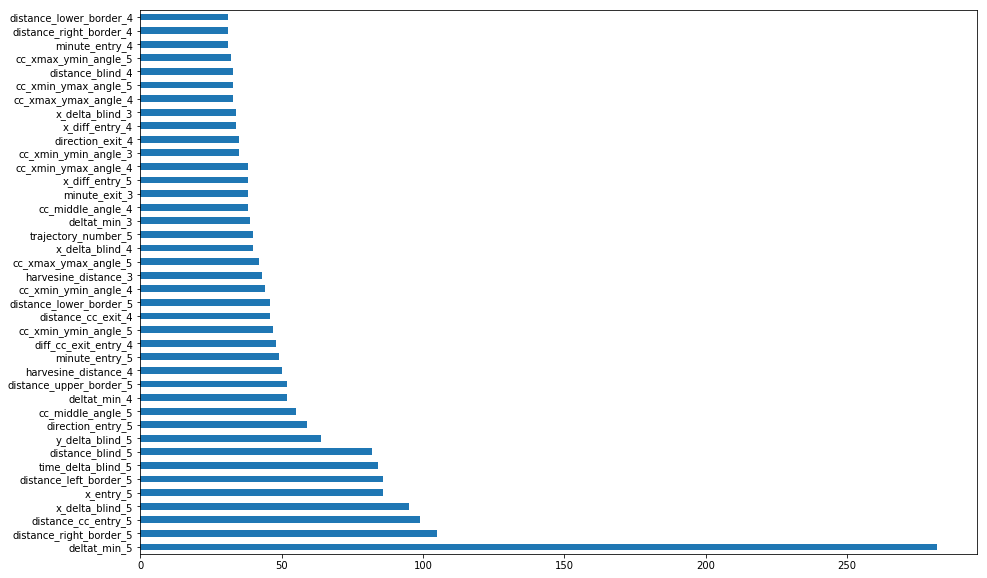

In [379]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(clf.feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(40).plot(kind='barh')

In [380]:
data_test = data_sequence[data_sequence.hash.isin(hashs_test)]
#data_test = test[test['x_exit_'+str(window_reference)].isnull()]

In [381]:
data_test.shape

(33515, 381)

In [382]:
ids = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
ids = ids[ids.x_exit.isnull()]

In [383]:
data_test = data_test.merge(ids[['hash', 'trajectory_id']], on='hash')

In [384]:
clf.fit(data_train[features], data_train[target])
yhat = clf.predict(data_test[features])

In [385]:
pd.Series(yhat).value_counts()

0.0    25049
1.0     8466
dtype: int64

In [387]:
data_test.head(4)

,hash,vmax_1,vmax_2,vmax_3,vmax_4,vmax_5,vmin_1,vmin_2,vmin_3,vmin_4,...,direction_exit_2,direction_exit_3,direction_exit_4,direction_exit_5,count_trajectories_1,count_trajectories_2,count_trajectories_3,count_trajectories_4,count_trajectories_5,trajectory_id
0,00032f51796fd5437b238e3a9823d13d_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.129398,0.084616,0.129028,NaN,NaN,4.0,4.0,4.0,4.0,traj_00032f51796fd5437b238e3a9823d13d_31_5
1,000479418b5561ab694a2870cc04fd43_25,NaN,NaN,17.29,NaN,NaN,NaN,NaN,17.29,NaN,...,NaN,3.053320,3.054282,NaN,NaN,NaN,3.0,3.0,3.0,traj_000479418b5561ab694a2870cc04fd43_25_10
2,000506a39775e5bca661ac80e3f466eb_29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.010185,NaN,NaN,NaN,NaN,2.0,2.0,traj_000506a39775e5bca661ac80e3f466eb_29_5
3,0005401ceddaf27a9b7f0d42ef1fbe95_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4


In [388]:
submission = pd.DataFrame(list(zip(data_test['trajectory_id'], yhat)), columns=['id', 'target'])

In [306]:
submission.to_csv('../data/submission38_julio.csv', index=False)